In [1]:
data_path = "./data"
model_weights_path = "./model-weights/yolo.pt"
model_path = '../docker-image/app/yolov5'

In [2]:
import os
import torch
from PIL import Image, ImageDraw
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

c:\Users\Avishka\Anaconda3\envs\ahead-aws\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LP Localization

In [3]:
plate_detection_model = torch.hub.load(model_path, 'custom', model_weights_path, source="local")

YOLOv5  2023-2-22 Python-3.8.16 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [4]:
# plate_detection_model = torch.hub.load('ultralytics/yolov5', 'custom', model_dict_path)
test_imgs = os.listdir(f"{data_path}/LP/images/val")
img = Image.open(f"{data_path}/LP/images/val/{test_imgs[50]}")
results = plate_detection_model(img)
results = results.pandas().xyxy[0]
annotations = results.apply(lambda row: (row["class"], row["xmin"], row["xmax"], row["ymin"], row["ymax"]), axis=1)
annotations

0    (0, 90.47074890136719, 156.4077911376953, 20.4...
dtype: object

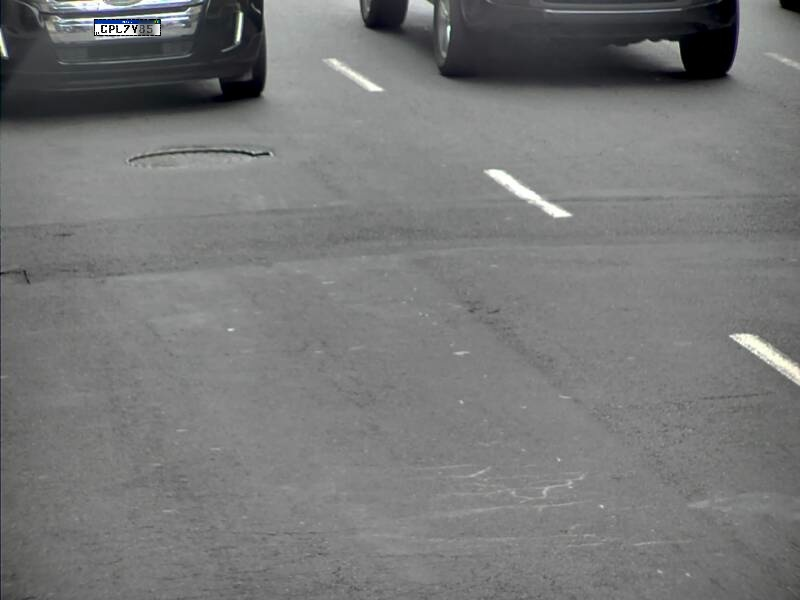

In [5]:
img

In [6]:
def show_bbox(image=None, annotations=None, format="x1x2y1y2"):

    # Open the image and create ImageDraw object for drawing
    image = image.copy()

    draw = ImageDraw.Draw(image)

    for line in annotations:
        # Split the line into five values
        label, x1, x2, y1, y2 = line

        if format == "xywh":
          label, x, y, w, h = line

          # Convert center position, width, height into
          # top-left and bottom-right coordinates
          W, H = image.size
          x1 = (x - w/2) * W
          y1 = (y - h/2) * H
          x2 = (x + w/2) * W
          y2 = (y + h/2) * H

        # Draw the bounding box with red lines
        draw.rectangle((x1, y1, x2, y2),
                        outline=(255, 0, 0), # Red in RGB
                        width=5)             # Line width
    display(image)

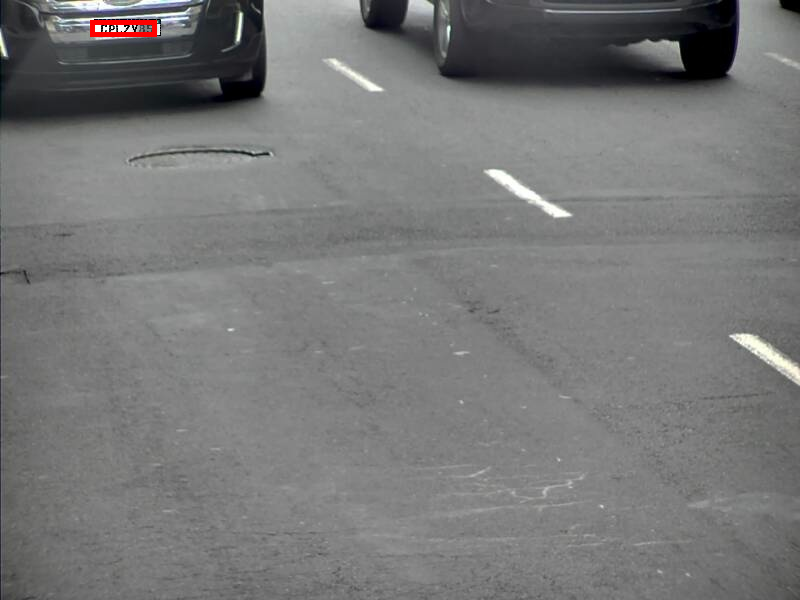

In [7]:
show_bbox(img, annotations)

In [8]:
img.size, annotations[0][1:]

((800, 600),
 (90.47074890136719,
  156.4077911376953,
  20.499420166015625,
  36.734317779541016))

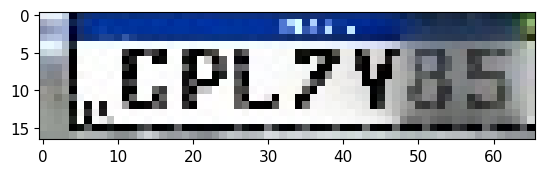

In [9]:
img_cv = np.array(img)
annotations.to_list()
_, xmin, xmax, ymin, ymax = annotations[0]
xmin,xmax,ymin,ymax = int(np.round(xmin)),int(np.round(xmax)),int(np.round(ymin)),int(np.round(ymax))
plate = img_cv[ymin:ymax, xmin:xmax, :]
%matplotlib inline
plt.imshow(plate)

# OCR

## Character Localization

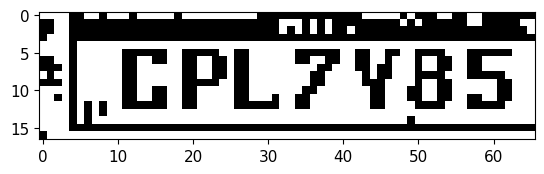

In [10]:
gray_plate = cv.cvtColor(plate, cv.COLOR_RGB2GRAY)
plate_thresh = cv.adaptiveThreshold(gray_plate,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,7,2)
plt.imshow(plate_thresh, cmap="gray")
contours, hierarchy = cv.findContours(plate_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
bounding_rects = tuple(map(cv.boundingRect, contours))

46.5

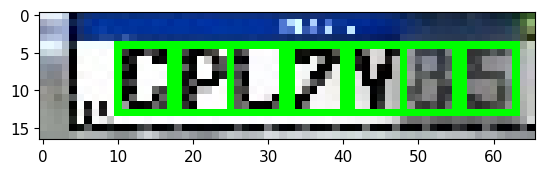

In [11]:
plate_height = plate.shape[0]
min_cnt_area = plate_height**2/15
min_bbox_area = plate_height**2/8
max_vert_scale_ratio, max_hori_scale_ratio = 2, 1.5
def isPlateChar(
        cnt,
        min_cnt_area=min_cnt_area,
        min_bbox_area=min_bbox_area,
        max_vert_scale_ratio=max_vert_scale_ratio,
        max_hori_scale_ratio=max_hori_scale_ratio,
        verbose=False
    ):
    cnt_area = cv.contourArea(cnt)
    if cnt_area < min_cnt_area: verbose and print(f"    Fail 1  : Contour area failed (Countour area ({cnt_area}) < Minimum required area ({min_cnt_area}))"); return False
    x,y,w,h = cv.boundingRect(cnt)
    if w*h < min_bbox_area:  verbose and print(f"    Fail 2  : BBox area failed (BBox area ({w*h}) < Minimum required area ({min_bbox_area}))"); return False
    if h>w and h/w>max_vert_scale_ratio:  verbose and print(f"    Fail 3 a: Max Vertical Scale Ratio failed (h/w ({h/w}) < Maximum ratio ({max_vert_scale_ratio}))"); return False
    if h<w and w/h>max_hori_scale_ratio:  verbose and print(f"    Fail 3 b: Max Horizontal Scale Ratio failed (w/h ({w/h}) < Maximum ratio ({max_hori_scale_ratio}))"); return False
    return True

# print("Filtering bounding boxes")
filtered_bboxs = tuple(map(cv.boundingRect, tuple(filter(isPlateChar, contours))))
chars = [{"pos":(box[0], box[1]), "img": plate_thresh[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]} for box in filtered_bboxs]
id = 3
drawn = plate.copy()
# cv.drawContours(drawn, contours, id, (0,255,0), 1)
for bbox in filtered_bboxs:
    x,y,w,h = bbox
    cv.rectangle(drawn,(x,y),(x+w-1,y+h-1),(0,255,0),1)
plt.imshow(drawn)
cv.contourArea(contours[id])

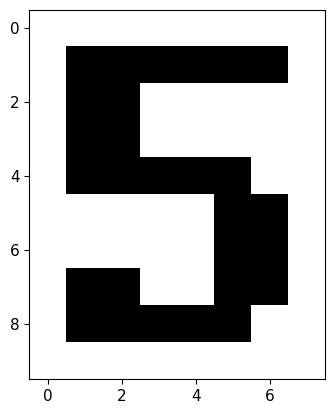

In [12]:
plt.imshow(chars[0]["img"], cmap="gray")

## Licence Number Resolver

In [13]:
from torch import nn
import torch.nn.functional as F

class CharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class NumberResolver():
    '''
    Returns the licence number when a class instance is called passing the localized number plate as an array
    '''
    def __init__(self, char_model_weights, device, char_shape=(28, 28)):
        char_model = CharModel()
        char_model.load_state_dict(torch.load(char_model_weights, map_location=device))
        self.char_model = char_model
        self.char_shape = char_shape
        self.device = next(char_model.parameters()).device
        self.class_labels = tuple(map(chr, list(np.hstack((np.arange(ord("A"), ord("Z")+1), np.arange(ord("0"), ord("9")+1))))))

    def isPlateChar(
                self,
                cnt,
                verbose=False
            ):
            min_cnt_area = self.plate_height**2/15
            min_bbox_area = self.plate_height**2/8
            max_vert_scale_ratio, max_hori_scale_ratio = 2, 1.5
    
            cnt_area = cv.contourArea(cnt)
            if cnt_area < min_cnt_area: verbose and print(f"    Fail 1  : Contour area failed (Countour area ({cnt_area}) < Minimum required area ({min_cnt_area}))"); return False
            x,y,w,h = cv.boundingRect(cnt)
            if w*h < min_bbox_area:  verbose and print(f"    Fail 2  : BBox area failed (BBox area ({w*h}) < Minimum required area ({min_bbox_area}))"); return False
            if h>w and h/w>max_vert_scale_ratio:  verbose and print(f"    Fail 3 a: Max Vertical Scale Ratio failed (h/w ({h/w}) < Maximum ratio ({max_vert_scale_ratio}))"); return False
            if h<w and w/h>max_hori_scale_ratio:  verbose and print(f"    Fail 3 b: Max Horizontal Scale Ratio failed (w/h ({w/h}) < Maximum ratio ({max_hori_scale_ratio}))"); return False
            return True
    
    def char2Model(self, char):
        '''
        Turns the character in to a square and resizes to self.char_shape
        '''
        new_char_img = char.copy()
        min_dim, max_dim = new_char_img.shape
        if min_dim != max_dim:
            wide = True
            if min_dim>max_dim:
                wide = False
                temp_min_dim, max_dim = max_dim, min_dim
                min_dim = temp_min_dim
            
            pad_count = int((max_dim-min_dim)/2)
            equal = True if pad_count == (max_dim-min_dim)/2 else False
            
            start_pad_count = pad_count
            end_pad_count = pad_count if equal else pad_count + 1
            
            if wide:
                start_pad = np.ones((start_pad_count, max_dim))*255
                end_pad = np.ones((end_pad_count, max_dim))*255
                new_char_img = np.vstack((start_pad, new_char_img, end_pad))
            else:
                start_pad = np.ones((max_dim, start_pad_count))*255
                end_pad = np.ones((max_dim, end_pad_count))*255
                new_char_img = np.hstack((start_pad, new_char_img, end_pad))

        new_char_img = cv.resize(new_char_img, self.char_shape).astype('uint8')
        _,new_char_img = cv.threshold(new_char_img,127,255,cv.THRESH_BINARY)

        new_char_img = new_char_img[np.newaxis, np.newaxis, :]
        new_char_img = new_char_img
        
        return new_char_img
         

    def __call__(self, plate: np.ndarray) -> str:
        self.plate_height = plate.shape[0]

        # get all contors
        gray_plate = cv.cvtColor(plate, cv.COLOR_RGB2GRAY)
        plate_thresh = cv.adaptiveThreshold(gray_plate,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
                    cv.THRESH_BINARY,7,2)
        contours, _ = cv.findContours(plate_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        # filter the contours and get bboxes
        filtered_bboxs = tuple(map(cv.boundingRect, tuple(filter(self.isPlateChar, contours))))
        chars = [{"pos":(box[0], box[1]), "img": plate_thresh[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]} for box in filtered_bboxs]

        # prepare the characters to be infered
        for char in chars:
            char["img"] = self.char2Model(char["img"])

        # make the predictions
        for char in chars:
            char_img = torch.Tensor(char["img"]).to(self.device)
            preds = self.char_model(char_img).squeeze()
            label_id = preds.argmax().item()
            label = self.class_labels[label_id]
            char["label"] = label
        
        # set the order
        chars = sorted(chars, key=lambda d: d['pos'][0]) 
        number = "".join(tuple(map(lambda x: str(x["label"]), chars)))

        # clean up the object for latter calls
        del self.plate_height

        return number

device = "cuda" if torch.cuda.is_available() else "cpu" 
nr = NumberResolver("./model-weights/char.pt", device)

CPL7YB5


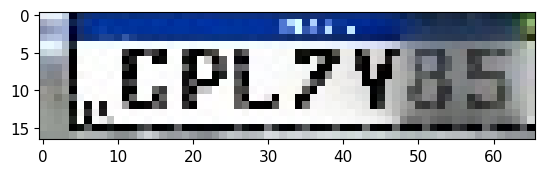

In [14]:
print(nr(plate))
plt.imshow(plate)